In [78]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.lines as mlines

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

# Colors
from palettable.colorbrewer.qualitative import Dark2_7
from palettable.colorbrewer.qualitative import Set1_7
from palettable.tableau import Tableau_10
col = Dark2_7.hex_colors
col2 = Tableau_10.hex_colors
col = Set1_7.hex_colors

from palettable.cubehelix import cubehelix3_16
cubehelix = cubehelix3_16.hex_colors

import seaborn as sns

# Testing resonant absorption

FORS2 resolution is low (R~1360), z~6 lines look broader on blue side than z~7 --> how much of reduced EW distribution could be due to resonant absorption? I.e. not damping wings??

# EW distribution

$$ p(W_7 | T, W_6) = p_6(W/T)/T $$

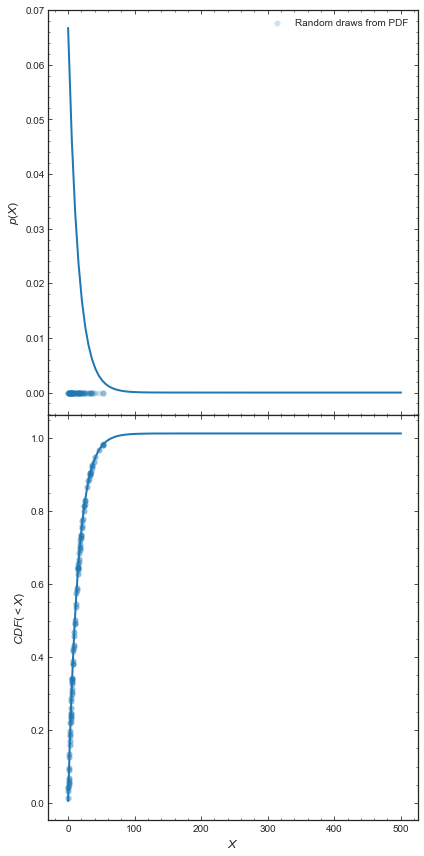

In [2]:
Wtab = np.linspace(0., 500, 100)

T = 0.5

def pW_exp(W, Wc=30, T=1.):
    return np.exp(-W/Wc/T)/Wc/T

pW_6 = pW_exp(W=Wtab)
pW_7 = pW_exp(W=Wtab, T=T)

W_T05_draw = reionizer.sample_from_pdf(pdf=pW_7, x=Wtab, plot=True, Ndraw=100)

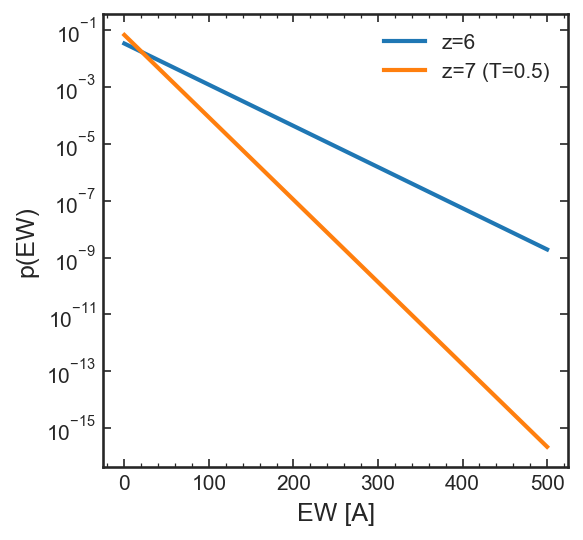

In [3]:
plt.figure(figsize=(4,4), dpi=150)
plt.semilogy(Wtab, pW_6, label='z=6')
plt.plot(Wtab, pW_7, label='z=7 (T=%.1f)' % T)

plt.xlabel('EW [A]')
plt.ylabel('p(EW)')
plt.legend()

In [6]:
def lnlikelihood(W, T):
    lnlike = np.log(pW_exp(W=W, Wc=T*30))
    lnlike_sum = np.sum(lnlike)
    if np.isnan(lnlike_sum):
        return -np.inf
    else:
        return lnlike_sum

def lnprior(T):
    if 0. <= T <= 1.:
        return 0.
    else:
        return -np.inf
    
def lnposterior(W, T):
    return lnlikelihood(W, T) + lnprior(T)

[           -inf -4.00375985e+04 -1.83103850e+04 -1.12423965e+04
 -7.79335177e+03 -5.77445925e+03 -4.46209009e+03 -3.54860454e+03
 -2.88140876e+03 -2.37640400e+03 -1.98353428e+03 -1.67120153e+03
 -1.41851047e+03 -1.21111266e+03 -1.03884304e+03 -8.94308667e+02
 -7.72010849e+02 -6.67779877e+02 -5.78399985e+02 -5.01353985e+02
 -4.34645381e+02 -3.76671923e+02 -3.26134100e+02 -2.81967835e+02
 -2.43294259e+02 -2.09381717e+02 -1.79616705e+02 -1.53481361e+02
 -1.30535882e+02 -1.10404638e+02 -9.27651308e+01 -7.73391241e+01
 -6.38854822e+01 -5.21943364e+01 -4.20823071e+01 -3.33885654e+01
 -2.59715682e+01 -1.97063370e+01 -1.44821790e+01 -1.02007683e+01
 -6.77452408e+00 -4.12523331e+00 -2.18287693e+00 -8.84624893e-01
 -1.73973190e-01  0.00000000e+00 -3.16722417e-01 -1.08253841e+00
 -2.25974127e+00 -3.81409586e+00 -5.71446787e+00 -7.93249850e+00
 -1.04423183e+01 -1.32202950e+01 -1.62448105e+01 -1.94960631e+01
 -2.29558928e+01 -2.66076248e+01 -3.04359309e+01 -3.44267052e+01
 -3.85669530e+01 -4.28446

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


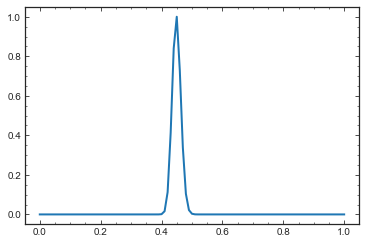

In [7]:
W_T05_draw = reionizer.sample_from_pdf(pdf=pW_7, x=Wtab, Ndraw=1000)

Ttry = np.linspace(0., 1., 101)

lnpost_T = np.array([lnposterior(W_T05_draw, T) for T in Ttry])
lnpost_T-= np.nanmax(lnpost_T[np.isfinite(lnpost_T)])
plt.plot(Ttry, np.exp(lnpost_T))
print(lnpost_T)
print(Ttry[np.argmax(np.exp(lnpost_T))])

# Lya emission line model

In [8]:
def lya_line_profile(v, red_to_blue_ratio=1., DV=100.):
    
    g_red  = reionizer.line_shape_gauss(v, vcenter=DV,  fwhm=DV, vmin=-1e5, plot=False)
    g_blue = reionizer.line_shape_gauss(v, vcenter=-DV, fwhm=DV, vmin=-1e5, plot=False)
    
    # add red + blue
    g_tot  = g_blue + red_to_blue_ratio*g_red
    
    # normalise
    g_tot /= np.trapz(g_tot, v)
    
    return g_tot
    

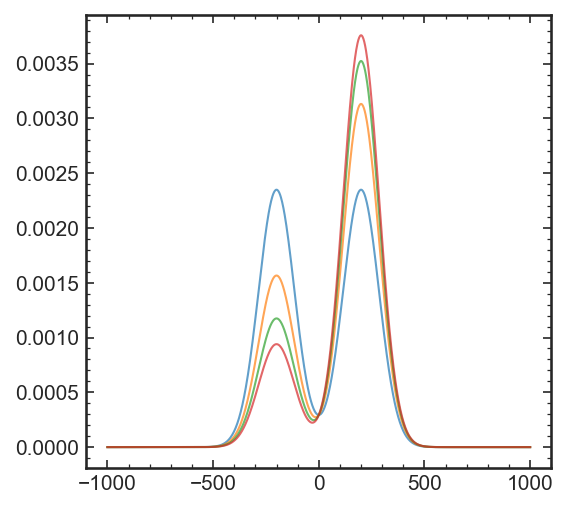

In [9]:
vtab = np.linspace(-1000, 1000, 1000)

plt.figure(figsize=(4,4), dpi=150)

red_blue = np.arange(1, 5)

for ratio in red_blue:
    plt.plot(vtab, lya_line_profile(vtab, red_to_blue_ratio=ratio, DV=200), lw=1, alpha=0.7)

# If blue peaks at z~6 how does EoR impact it?

## Damping wing optical depths

Loaded 40 damping wing optical depth tables
[0.01 0.02 0.05 0.07 0.09 0.12 0.15 0.18 0.22 0.25 0.29 0.32 0.36 0.39
 0.42 0.45 0.49 0.52 0.55 0.58 0.61 0.64 0.66 0.69 0.72 0.74 0.76 0.78
 0.8  0.82 0.84 0.86 0.87 0.89 0.9  0.91 0.92 0.93 0.94 0.95]


(0, 1.1)

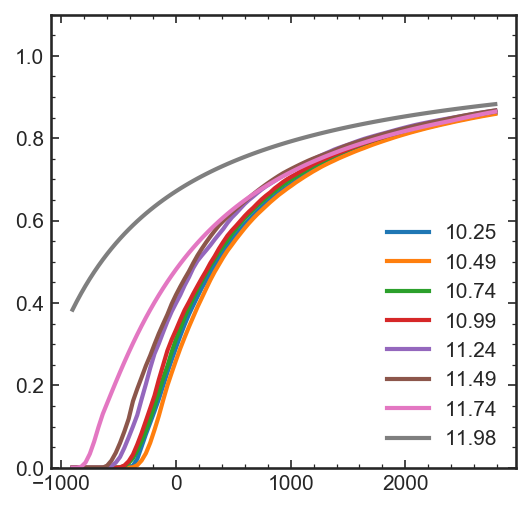

In [106]:
# Load tables
tabs = sorted(reionizer.insensitive_glob(os.environ['LYA_DATA_DIR']+'data/withMh_FaintGals_Tot_Tau_lists/z7*'))
# tabs = sorted(KT.insensitive_glob('../data/withMh_BrightGal_Tot_Tau_lists/Z7.0*'))
print('Loaded',len(tabs),'damping wing optical depth tables')

# Get DV
tab_header = open(tabs[0])
header = tab_header.readline()
line = header.strip().split()
tab_header.close()
deltaV = np.array([-float(v) for v in line[4:]])

# Get xHI
xHI = np.array([float(f.split('nf')[-1]) for f in tabs])
print(xHI)
    
def get_tau_med(t):

    tab = pd.read_csv(t, sep='\t', skiprows=(1,1))
    tab = tab.drop(tab.index[[0]])
    tab = tab.drop(['Xpos','Ypos','Zpos'], 1) 

#     mass = np.unique(np.log10(tab['Mass']))
    
    mass_tab = tab.groupby(['Mass'])
    med_optdepth = np.exp(-mass_tab.median())
    
    min_optdepth = np.exp(-mass_tab.quantile(.84))
    max_optdepth = np.exp(-mass_tab.quantile(.16))
    
    del tab
    
    return med_optdepth, min_optdepth, max_optdepth

def get_tau_all(t):

    tab = pd.read_csv(t, sep='\t', skiprows=(1,1))
    tab = tab.drop(tab.index[[0]])
    tab = tab.drop(['Xpos','Ypos','Zpos','Mass'], 1) 
    
    optdepth = np.exp(-tab)
    
    del tab
    
    return optdepth

med_optdepth, min_optdepth, max_optdepth = get_tau_med(tabs[20])
mass = med_optdepth.index

plt.figure(figsize=(4,4), dpi=150)
for i,row in med_optdepth[::2].iterrows():
    plt.plot(deltaV, row, label='%.2f' % np.log10(i))
plt.legend()

plt.ylim(0, 1.1)

## Impact of optical depth on emission line

Text(0, 0.5, 'Flux density')

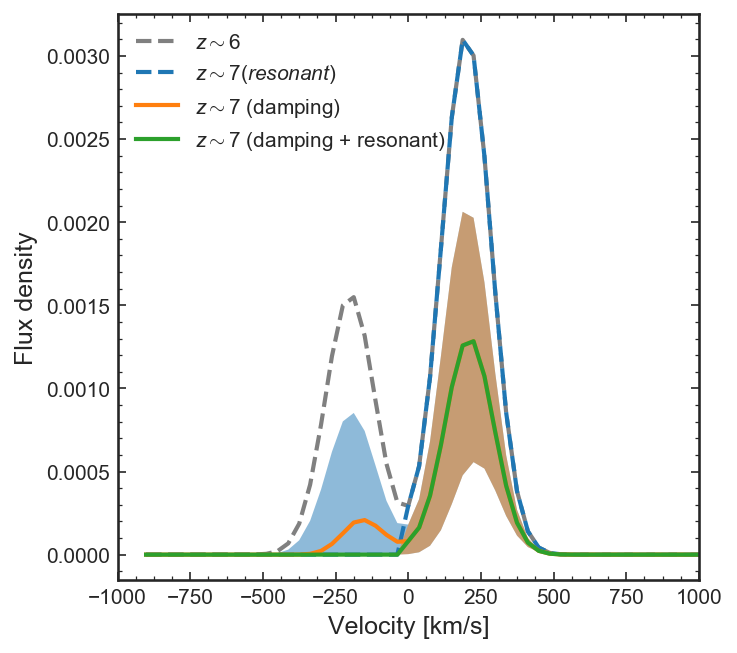

In [93]:
# %lprun -f get_tau_all get_tau_all(tabs[0])
optdepth = get_tau_all(tabs[20])

J_6               = lya_line_profile(deltaV, red_to_blue_ratio=2., DV=200)
J_7_damp          = optdepth*J_6
J_7_damp_plus_res = J_7_damp.copy()
J_7_damp_plus_res.iloc[:,np.where(deltaV < 0.)[0]] = 0.
J_7_res = J_6.copy()
J_7_res[np.where(deltaV < 0.)[0]] = 0.

# Plot figs
plt.figure(figsize=(5,5), dpi=150)

plt.plot(deltaV, J_6, c='0.5', ls='dashed', label='$z\sim6$')

plt.plot(deltaV, J_7_res, ls='dashed', label='$z\sim7 (resonant)$')

plt.plot(deltaV, np.median(J_7_damp, axis=0), label='$z\sim7$ (damping)')
plt.fill_between(deltaV, np.percentile(J_7_damp, 16, axis=0), np.percentile(J_7_damp, 84, axis=0), alpha=0.5)

plt.plot(deltaV, np.median(J_7_damp_plus_res, axis=0), label='$z\sim7$ (damping + resonant)')
plt.fill_between(deltaV, np.percentile(J_7_damp_plus_res, 16, axis=0), np.percentile(J_7_damp_plus_res, 84, axis=0), alpha=0.5)

plt.legend()
plt.xlim(-1000, 1000)

plt.xlabel('Velocity [km/s]')
plt.ylabel('Flux density')

## Lya transmission

Transmission including resonant absorption always < fraction in the red peak (fraction remaining after resonant absorption)

That means that as long as the difference in transmission due to resonant absorption is low between z~6 - z~7, we should expect a big decrease in transmission due to that

Text(0.5, 0, 'Lya transmission')

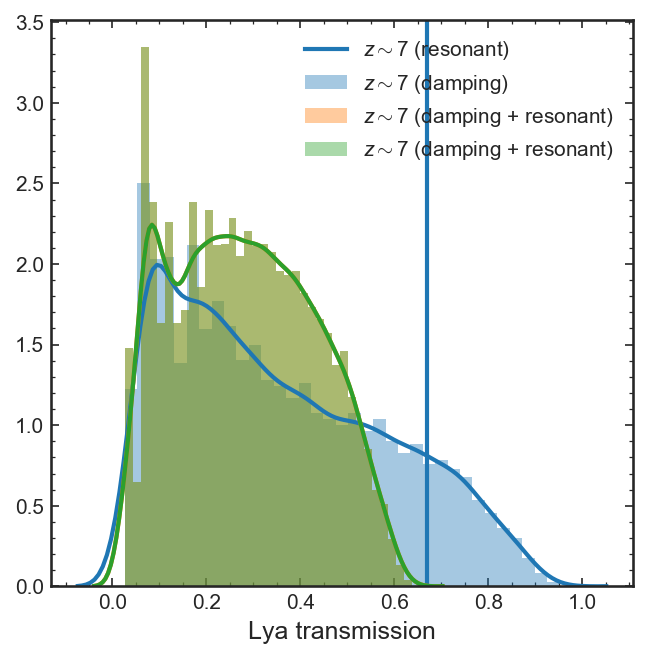

In [105]:
J_6               = lya_line_profile(deltaV, red_to_blue_ratio=2, DV=200)
J_7_damp          = optdepth*J_6
J_7_damp_plus_res = J_7_damp.copy()
J_7_damp_plus_res.iloc[:,np.where(deltaV < 0.)[0]] = 0.
J_7_res = J_6.copy()
J_7_res[np.where(deltaV < 0.)[0]] = 0.

plt.figure(figsize=(5,5), dpi=150)

trans_z6 = np.trapz(J_6, deltaV)

trans_z7_resonly         = np.trapz(J_7_res, deltaV)/trans_z6
trans_z7_dampingonly     = np.trapz(J_7_damp, deltaV)/trans_z6
trans_z7_damping_plusres = np.trapz(J_7_damp_plus_res, deltaV)/trans_z6

plt.axvline(trans_z7_resonly, label='$z\sim7$ (resonant)')
sns.distplot(trans_z7_dampingonly, label='$z\sim7$ (damping)')
sns.distplot(trans_z7_damping_plusres, label='$z\sim7$ (damping + resonant)')
sns.distplot(trans_z7_damping_plusres[trans_z7_damping_plusres < trans_z7_resonly], label='$z\sim7$ (damping + resonant)')

plt.legend()

plt.xlabel('Lya transmission')

In [109]:
def tau_GP(z):
    return (1. + z)**3.

print(tau_GP(z=7.)-tau_GP(z=6.))
print(np.exp(-(tau_GP(z=7.)-tau_GP(z=6.))))

169.0
4.020060215743355e-74
